In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2

from generateEnvironment import GenerateEnvironment, GenerateConstraints, SolveProblem

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
def FDP_Power_L2(beta_hat, beta_0, threshold):
    discoveries = set(np.where(np.abs(beta_hat)>threshold)[0])
    truth = set(np.where(np.abs(beta_0)>0)[0])
    power = len(discoveries.intersection(truth))/np.maximum(len(truth),1)
    fdp = len(discoveries.difference(truth))/np.maximum(len(discoveries),1)
    l2 = np.linalg.norm(beta_hat-beta_0)
    return fdp,power,l2

In [3]:
store_df = pd.DataFrame(columns=['n_dim','n_constraints','n_samples','lmbda','threshold','FDP_DZ','Power_DZ','L2_DZ','FDP_LR','Power_LR','L2_LR'])

In [ ]:
h_dim=2
n_reps=20
for n_dim in np.array([10,30,50,100,200,500]):
    for n_constraints_float in np.array([0.2,0.5,0.8]):
        n_constraints=int((n_dim-h_dim)*n_constraints_float)
        for n_samples in np.array([1000,2000,10000,50000,200000]):
            for lmbda in np.array([0.0001,0.001,0.01,0.1,1]):
                for rep in np.arange(n_reps):
                    try:
                        x_indices = np.arange(h_dim,n_dim-1)
                        xy_indices = np.arange(h_dim,n_dim)
                        constraints_indices = x_indices[:n_constraints]
                        connectivity_e0 = (np.random.binomial(n=10,p=0.2, size= (n_dim,n_dim))-2) * (np.ones((n_dim,n_dim))-np.eye(n_dim))
                        connectivity_e0[-1,:] *= np.random.binomial(n=4,p=0.05, size=n_dim)
                        connectivity_e0[:,-1] = 0
                        connectivity_e0[:h_dim,:] = 0
                        connectivity_e0[-1,0] = 2
                        covariance_e0 = np.eye(n_dim)
                        
                        generate_environment = GenerateEnvironment(connectivity_e0)
                        constraints = GenerateConstraints(n_dim)
                        
                        constraints.add_constraints_env(generate_environment.generate_intervention(n_samples, {i:'independent' for i in constraints_indices}), {i:'independent' for i in constraints_indices})
                        
                        solver = SolveProblem(len(x_indices))
                        solver.load_constraints(constraints.array_constraints, x_indices)
                        solver.load_obs_dataset(generate_environment.generate_intervention(n_samples, {}))
                        
                        problem = solver.solve_problem(lmbda, x_indices)
                        beta_DZ = problem.variables()[0].value
                        beta_LR = generate_environment.estimator_LR(n_samples, x_indices)
                        beta = connectivity_e0[-1,x_indices]
                        for threshold in np.array([0.05,0.1,0.2,0.5,1]):
                            store_df = store_df.append(pd.Series(
                                index=['n_dim','n_constraints','n_samples','lmbda','threshold','FDP_DZ','Power_DZ','L2_DZ','FDP_LR','Power_LR','L2_LR'],
                                data=[n_dim,n_constraints,n_samples,lmbda,threshold,*FDP_Power_L2(beta_DZ, beta, threshold),*FDP_Power_L2(beta_LR, beta, threshold)]),
                                            ignore_index=True)
                            store_df.to_pickle('store_df.pkl')
                    except:
                        pass

In [ ]:
store_df[store_df['n_dim']==500]

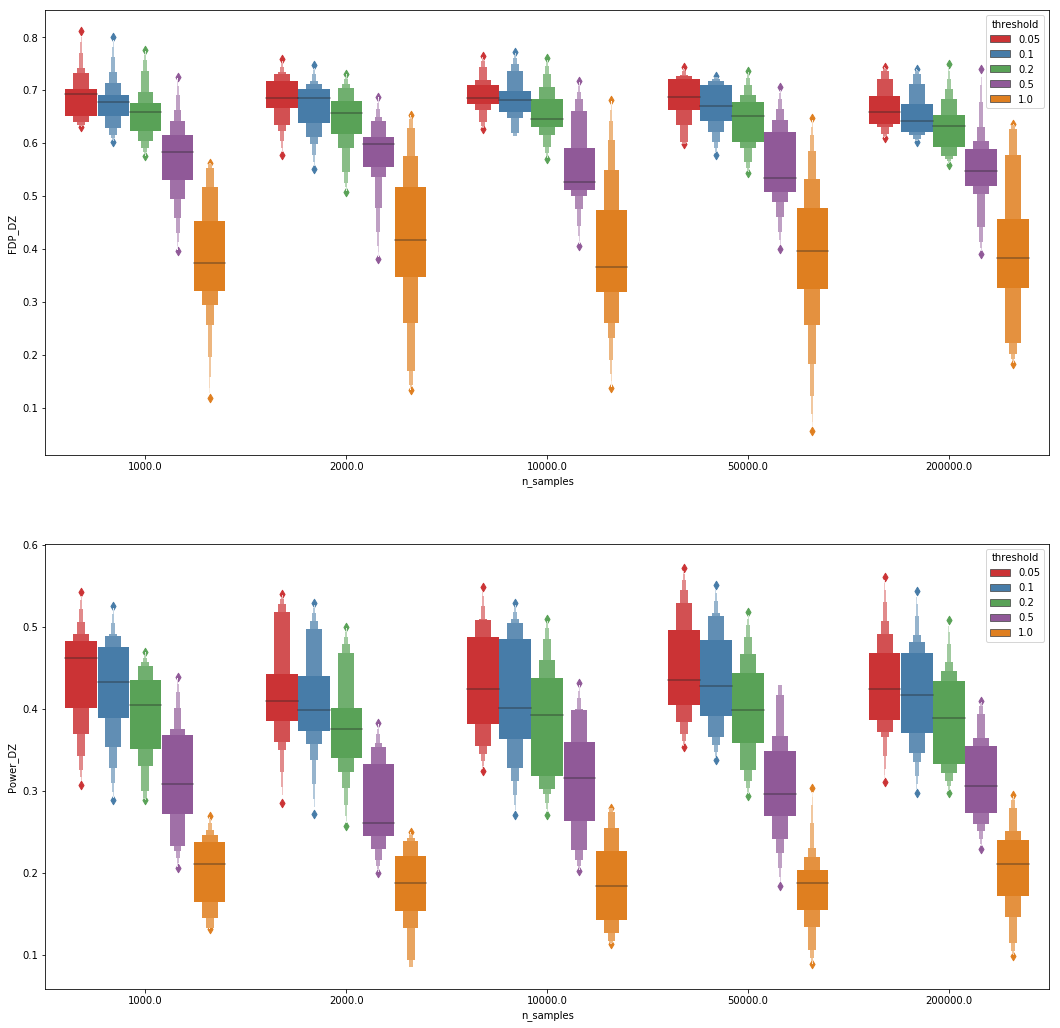

In [56]:
n_constraints=99
lmbda=1e-1
n_dim=500

fig, ax = plt.subplots(figsize=(18,18),nrows=2)

sns.boxenplot(x="n_samples", y="FDP_DZ", hue="threshold", data=store_df[(store_df['n_dim']==n_dim)
                                                                        &(store_df['n_constraints']==n_constraints)
                                                                       &(store_df['lmbda']==lmbda)], palette="Set1", ax = ax[0])

sns.boxenplot(x="n_samples", y="Power_DZ", hue="threshold", data=store_df[(store_df['n_dim']==n_dim)
                                                                        &(store_df['n_constraints']==n_constraints)
                                                                       &(store_df['lmbda']==lmbda)], palette="Set1", ax = ax[1])




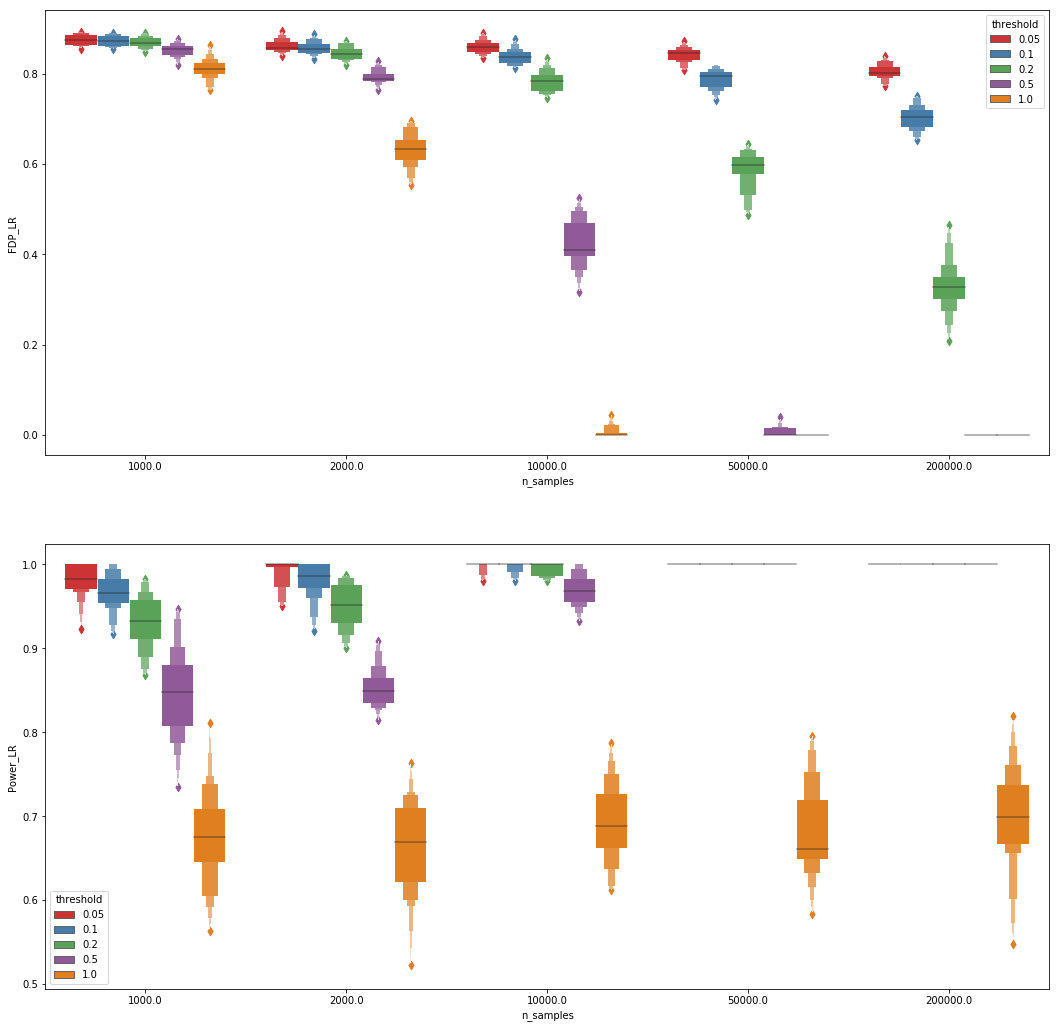

In [57]:
fig, ax = plt.subplots(figsize=(18,18),nrows=2)

sns.boxenplot(x="n_samples", y="FDP_LR", hue="threshold", data=store_df[(store_df['n_dim']==n_dim)
                                                                        &(store_df['n_constraints']==n_constraints)
                                                                       &(store_df['lmbda']==lmbda)], palette="Set1", ax = ax[0])

sns.boxenplot(x="n_samples", y="Power_LR", hue="threshold", data=store_df[(store_df['n_dim']==n_dim)
                                                                        &(store_df['n_constraints']==n_constraints)
                                                                       &(store_df['lmbda']==lmbda)], palette="Set1", ax = ax[1])


